# Class 2 - Shortcut Learning

## Introduction to the problem

Deep neural networks often solve problems by taking shortcuts instead of learning the
intended solution, leading to a lack of generalisation and unintuitive failures. This pattern can be
observed in many real-world applications

Food for thought: what is the equivalent issue in your area of expertise?

### References

https://arxiv.org/pdf/2004.07780.pdf

## Capture the problem

### From the paper

Reproduce *Fig 2*:
> During training, stars were always shown in the top right or bottom left of an image; moons in the top left or bottom right. 
This pattern is still present in samples from the i.i.d. test set (middle row) but not in o.o.d. test images (bottom row), exposing the shortcut.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys
from torchvision.utils import make_grid as make_grid
#from PIL import Image
import requests
from io import BytesIO
import cv2
from resizeimage import resizeimage

### Data

In [4]:
bunny = np.load('../shortcut/bunny.npy')
cow = np.load('../shortcut/cow.npy')

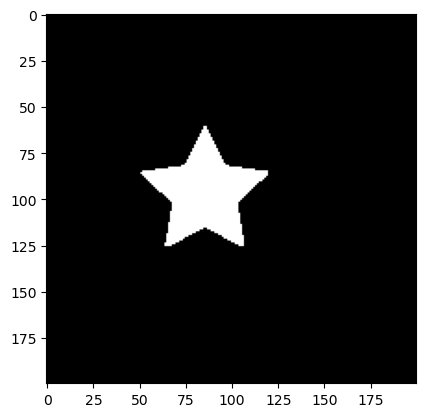

In [10]:
num_rows, num_cols = bunny.shape[:2]
# bottom right: 46 39 to 60 70
translation_matrix = np.float32([ [1,0,0], [0,1,0] ])
var = cow # bunny
img_translation = cv2.warpAffine(var, translation_matrix, (num_cols, num_rows))
plt.imshow(img_translation,cmap='gray')

In [11]:
biased_train_bun = []
biased_train_cow = []
unbiased_train_bun = []
unbiased_train_cow = []

In [12]:
for i in range(1000):
  
  x_val = np.random.randint(46,60)
  y_val = np.random.randint(39,70)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(bunny, translation_matrix, (200, 200))
  biased_train_bun.append(im)
  x_val = np.random.randint(-53,-39)
  y_val = np.random.randint(-65,-34)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(bunny, translation_matrix, (200, 200))
  biased_train_bun.append(im)
  
  y_val = np.random.randint(44,64)
  x_val = np.random.randint(-46,-22)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (200, 200))
  biased_train_cow.append(im)
  y_val = np.random.randint(-56,-33)
  x_val = np.random.randint(55,78)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (200, 200))
  biased_train_cow.append(im)
  

for i in range(2000):
  
  x_val = np.random.randint(-53,60)
  y_val = np.random.randint(-65,70)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(bunny, translation_matrix, (200, 200))
  unbiased_train_bun.append(im)
  
  y_val = np.random.randint(-56,64)
  x_val = np.random.randint(-46,78)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (200, 200))
  unbiased_train_cow.append(im)

In [13]:
biased_train_cow = np.array(biased_train_cow)
biased_train_bun = np.array(biased_train_bun)
unbiased_train_cow = np.array(unbiased_train_cow)
unbiased_train_bun = np.array(unbiased_train_bun)

In [14]:
unbiased_squares = unbiased_train_cow
unbiased_hearts = unbiased_train_bun
biased_squares = biased_train_cow
biased_hearts = biased_train_bun

In [42]:
some_unbiased_squares = unbiased_squares[:25]
np.random.shuffle(some_unbiased_squares)
some_unbiased_hearts = unbiased_hearts[:25]
np.random.shuffle(some_unbiased_hearts)
some_biased_squares = biased_squares[:25]
np.random.shuffle(some_biased_squares)
some_biased_hearts = biased_hearts[:25]
np.random.shuffle(some_biased_hearts)

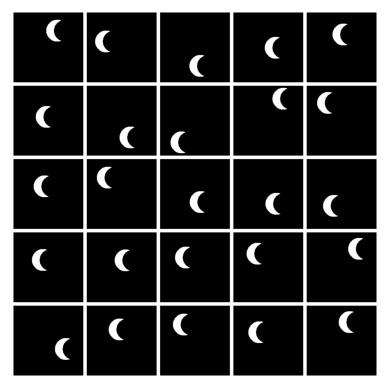

In [48]:
data_to_viz = "moons"
assert data_to_viz in ["stars", "moons"]
data_to_grid = some_unbiased_hearts if data_to_viz == "moons" else some_unbiased_squares
grid = make_grid(torch.from_numpy(np.float32(data_to_grid)).view(25,1,200,200),nrow=5,pad_value=1,padding=10)
plt.axis('off')
plt.imsave(f'../shortcut/unbiased_{data_to_viz}.png',grid.numpy().transpose(1,2,0))
plt.imshow(grid.numpy().transpose(1,2,0))

In [44]:
unbiased_data = np.concatenate((unbiased_squares,unbiased_hearts))
unbiased_data = torch.from_numpy(np.float32(unbiased_data))
labels = np.concatenate((np.zeros(len(unbiased_squares)),np.ones(len(unbiased_squares))))
labels = torch.from_numpy(labels).long()
biased_data = np.concatenate((biased_squares,biased_hearts))
biased_data = torch.from_numpy(np.float32(biased_data))

In [30]:
train_data = utils.TensorDataset(biased_data,labels) 
train_loader = utils.DataLoader(train_data,batch_size=100,shuffle=True) 
test_data = utils.TensorDataset(unbiased_data,labels) 
test_loader = utils.DataLoader(test_data,batch_size=100)

### Model

In [23]:
# Build FC net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(200*200, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.c1 = nn.Conv2d(1, 32, 5, 1, padding=2)
        self.c2 = nn.Conv2d(32, 32, 5, 1, padding=2)
        self.c3 = nn.Conv2d(32, 32, 5, 1, padding=2)
        self.pool = nn.AvgPool2d(200)
        self.fc = nn.Linear(32, 2)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [24]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.c1 = nn.Conv2d(1, 128, 5,stride=2,padding=2)
        self.c2 = nn.Conv2d(128, 128, 5,stride=2,padding=2)
        self.c3 = nn.Conv2d(128, 128, 5,stride=2,padding=2)
        self.pool = nn.AvgPool2d(25)
        self.fc = nn.Linear(128, 2)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [25]:
net = Net()

In [26]:
lr = 0.001
bs = 100
epochs = 100
log_interval = 10

In [27]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#criterion = nn.MSELoss()     
criterion = nn.CrossEntropyLoss()

In [28]:
epochs = 5

for epoch in range(epochs):
    total = 0.
    correct = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data = data.view(-1, 200*200)
        target = target.squeeze()
        optimizer.zero_grad()
        net_out = net(data).squeeze()
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                           100 * batch_idx / len(train_loader), loss.item()))
            
        _, predicted = torch.max(net_out.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print('Train Acc: '+str(correct/total))

Train Epoch: 1 [0/4000 (0%)]	Loss: 0.688216
Train Epoch: 1 [1000/4000 (25%)]	Loss: 0.000000
Train Epoch: 1 [2000/4000 (50%)]	Loss: 0.000000
Train Epoch: 1 [3000/4000 (75%)]	Loss: 0.000000
Train Epoch: 2 [0/4000 (0%)]	Loss: 0.000000
Train Epoch: 2 [1000/4000 (25%)]	Loss: 0.000000
Train Epoch: 2 [2000/4000 (50%)]	Loss: 0.000000
Train Epoch: 2 [3000/4000 (75%)]	Loss: 0.000000
Train Epoch: 3 [0/4000 (0%)]	Loss: 0.000000
Train Epoch: 3 [1000/4000 (25%)]	Loss: 0.000000
Train Epoch: 3 [2000/4000 (50%)]	Loss: 0.000000
Train Epoch: 3 [3000/4000 (75%)]	Loss: 0.000000
Train Epoch: 4 [0/4000 (0%)]	Loss: 0.000000
Train Epoch: 4 [1000/4000 (25%)]	Loss: 0.000000
Train Epoch: 4 [2000/4000 (50%)]	Loss: 0.000000
Train Epoch: 4 [3000/4000 (75%)]	Loss: 0.000000
Train Epoch: 5 [0/4000 (0%)]	Loss: 0.000000
Train Epoch: 5 [1000/4000 (25%)]	Loss: 0.000000
Train Epoch: 5 [2000/4000 (50%)]	Loss: 0.000000
Train Epoch: 5 [3000/4000 (75%)]	Loss: 0.000000
Train Acc: 1.0


In [29]:
total = 0.
correct = 0.
for idx, (data, target) in enumerate(test_loader):
  #data, target = Variable(data).cuda(), Variable(target).cuda()
  data, target = Variable(data), Variable(target)
  data = data.view(-1, 200*200)
  optimizer.zero_grad()
  net_out = net(data).squeeze()
  _, predicted = torch.max(net_out.data, 1)
  total += target.size(0)
  correct += (predicted == target).sum().item()
print('Test Acc: '+str(correct/total))

Test Acc: 0.5055


### Another example of shortcut learning

https://github.com/NeurAI-Lab/InBiaseD

https://github.com/NinaWie/featout

https://thegradient.pub/shortcuts-neural-networks-love-to-cheat/

https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002683

Real case study: hospital

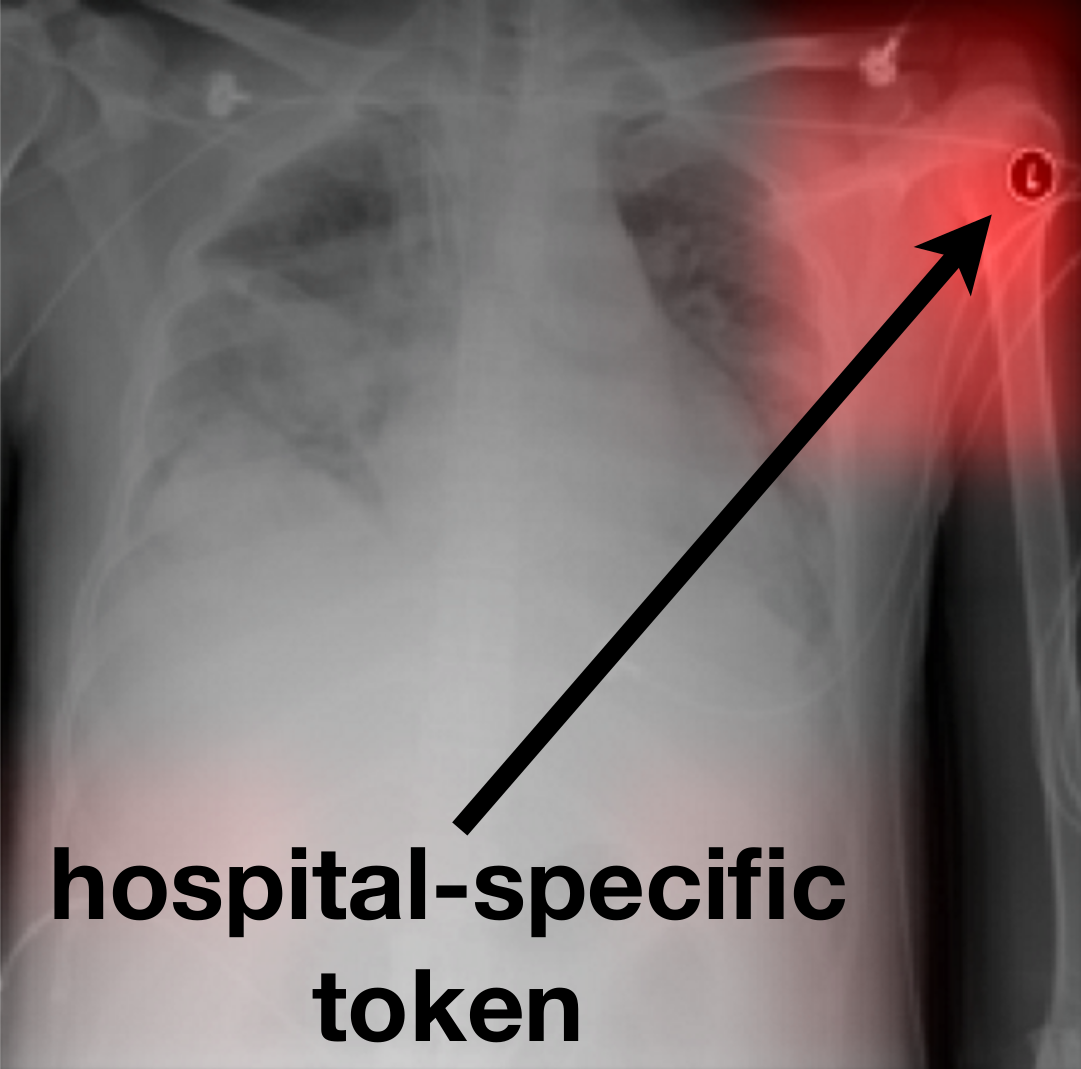

code from https://arxiv.org/pdf/2203.09860.pdf & https://github.com/LLYXC/PBBL

### Our first observation is that bias-imbalanced training data leads to a biased classifier

In [ ]:
!pip install torchxrayvision

### Pseudo Bias Balanced Learning

Explore more https://github.com/i6092467/diff-bias-proxies

https://github.com/YyzHarry/shortcut-ood-fairness

## Discover solutions

Think about potential solutions that may mitigate the effect